In [27]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_auc_score, precision_recall_curve, 
                           average_precision_score)
import shap
warnings.filterwarnings("ignore")

### Set global style for plots

In [28]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")
plt.rcParams['axes.grid'] = True

In [29]:
def load_numerical_model(model_path):
    """Load numerical model with metadata"""
    try:
        model_data = joblib.load(model_path)
        if not isinstance(model_data, dict) or 'model' not in model_data:
            raise ValueError("Invalid model format - missing metadata")
        return (
            model_data['model'],
            model_data['feature_names'],
            model_data['model_params']
        )
    except Exception as e:
        raise ValueError(f"Error loading model: {str(e)}")

In [30]:
def prepare_numerical_input(input_data, feature_names):
    """Prepare numerical input data for prediction"""
    try:
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        else:
            input_df = input_data.copy()

        for feature in feature_names:
            if feature not in input_df.columns:
                input_df[feature] = 0

        input_df = input_df[feature_names]
        return input_df

    except Exception as e:
        raise ValueError(f"Input preparation failed: {str(e)}")

In [31]:
def generate_shap_plots(model, X_test, feature_names, example_idx=0):
    """Generate SHAP plots with proper formatting"""
    try:
        print("\nGenerating SHAP explanations...")
        explainer = shap.TreeExplainer(model.named_steps['classifier'])
        shap_values = explainer.shap_values(X_test)
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar', show=False)
        plt.title('SHAP Feature Importance', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
        # Force plot for example transaction
        print("\nGenerating SHAP force plot...")
        plt.figure(figsize=(12, 4))
        shap.force_plot(explainer.expected_value, 
                       shap_values[example_idx,:], 
                       X_test.iloc[example_idx,:], 
                       feature_names=feature_names,
                       matplotlib=True,
                       show=False)
        plt.title(f'SHAP Explanation for Transaction #{example_idx}', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\nSHAP visualization error: {str(e)}")

In [38]:
def main():
    MODEL_PATH = '../assets/fraud_detection_model_numerical.pkl'
    TEST_DATA_PATH = '../assets/preprocessed_fraud_dataset_numerical_only.csv'
    
    try:
        # 1. Load model and data
        print("Loading model and data...")
        model, feature_names, model_params = load_numerical_model(MODEL_PATH)
        test_data = pd.read_csv(TEST_DATA_PATH)
        X_test_raw = test_data.drop('Fraud_Label', axis=1)
        y_test = test_data['Fraud_Label']
        X_test = prepare_numerical_input(X_test_raw, feature_names)
        
        # 2. Example prediction (show this first)
        print("\n" + "="*50)
        print("FRAUD DETECTION SYSTEM - PREDICTION RESULTS")
        print("="*50)
        
        example_transaction = {
            'Transaction_Amount': 1500,
            'Account_Balance': 5000,
            'IP_Address_Flag': 1,
            'Previous_Fraudulent_Activity': 0,
            'Daily_Transaction_Count': 10,
            'Avg_Transaction_Amount_7d': 200,
            'Failed_Transaction_Count_7d': 2,
            'Transaction_Distance': 1500,
            'Risk_Score': 0.05,
            'Is_Weekend': 0,
            'Hour': 3,
            'DayOfWeek': 4,
            'Is_Night': 1,
            'Amount_to_Balance_Ratio': 0.3,
            'Amount_Deviation': 1300,
        }
        
        prepared_input = prepare_numerical_input(example_transaction, feature_names)
        prediction = model.predict(prepared_input)[0]
        probability = model.predict_proba(prepared_input)[0, 1]
        
        print("\n=== TRANSACTION DETAILS ===")
        for k, v in example_transaction.items():
            print(f"{k:>30}: {v}")
        
        print("\n=== PREDICTION ===")
        print(f"{'Prediction:':>30} {'FRAUD' if prediction == 1 else 'LEGITIMATE'}")
        print(f"{'Fraud Probability:':>30} {probability:.4f}")
        
        if probability > 0.5:
            print("\n" + "!"*50)
            print("ALERT: This transaction is highly likely to be fraudulent!")
            print("!"*50)
        else:
            print("\nThis transaction appears legitimate.")
        
        # 3. Now show all visualizations
        print("\n" + "="*50)
        print("MODEL EVALUATION VISUALIZATIONS")
        print("="*50)
        
        # Make predictions for entire test set
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Confusion Matrix
        print("\nGenerating Confusion Matrix...")
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Legitimate', 'Fraud'],
                   yticklabels=['Legitimate', 'Fraud'])
        plt.title('Confusion Matrix', fontsize=14, pad=20)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()
        
        # Precision-Recall Curve
        print("\nGenerating Precision-Recall Curve...")
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, marker='.', linewidth=2)
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve', fontsize=14, pad=20)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Feature Importance
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            print("\nGenerating Feature Importance Plot...")
            importances = model.named_steps['classifier'].feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
            plt.title('Top 15 Feature Importances', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
        
        # SHAP Plots
        generate_shap_plots(model, X_test[:100], feature_names)  # Use subset for faster rendering
        
        # Print metrics
        print("\n=== MODEL PERFORMANCE METRICS ===")
        print(classification_report(y_test, y_pred))
        print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"Average Precision Score: {average_precision_score(y_test, y_proba):.4f}")
        
    except Exception as e:
        print(f"\nERROR: {str(e)}", file=sys.stderr)
        sys.exit(1)

Loading model and data...

FRAUD DETECTION SYSTEM - PREDICTION RESULTS

=== TRANSACTION DETAILS ===
            Transaction_Amount: 1500
               Account_Balance: 5000
               IP_Address_Flag: 1
  Previous_Fraudulent_Activity: 0
       Daily_Transaction_Count: 10
     Avg_Transaction_Amount_7d: 200
   Failed_Transaction_Count_7d: 2
          Transaction_Distance: 1500
                    Risk_Score: 0.05
                    Is_Weekend: 0
                          Hour: 3
                     DayOfWeek: 4
                      Is_Night: 1
       Amount_to_Balance_Ratio: 0.3
              Amount_Deviation: 1300

=== PREDICTION ===
                   Prediction: FRAUD
            Fraud Probability: 0.8810

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ALERT: This transaction is highly likely to be fraudulent!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

MODEL EVALUATION VISUALIZATIONS

Generating Confusion Matrix...


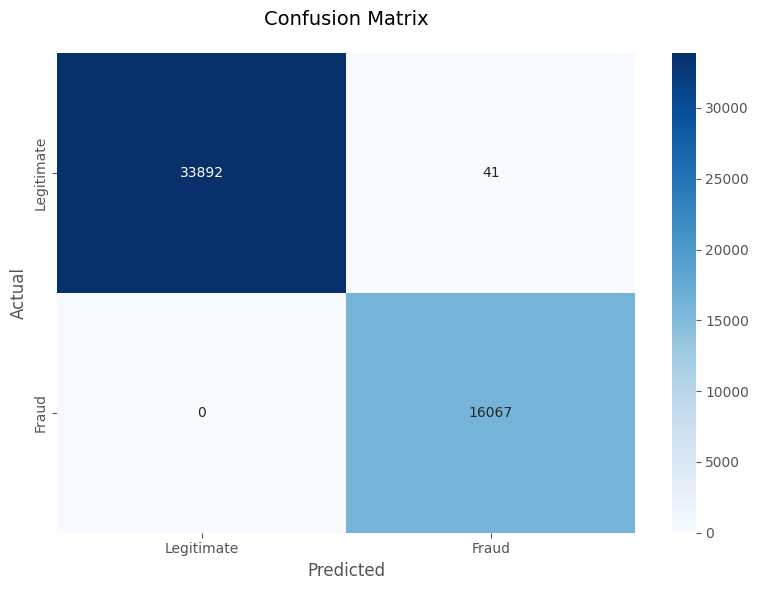


Generating Precision-Recall Curve...


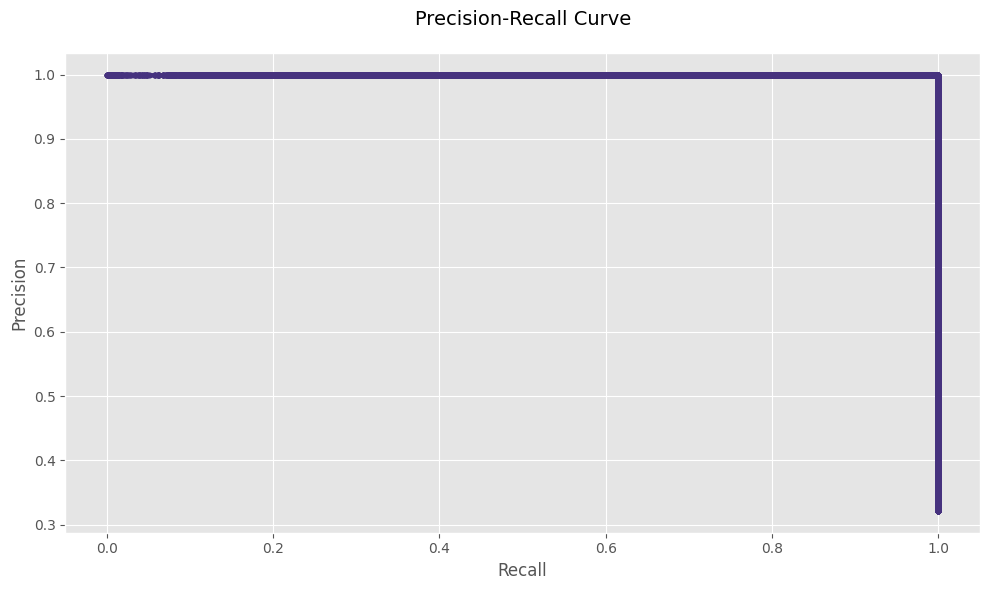


Generating Feature Importance Plot...


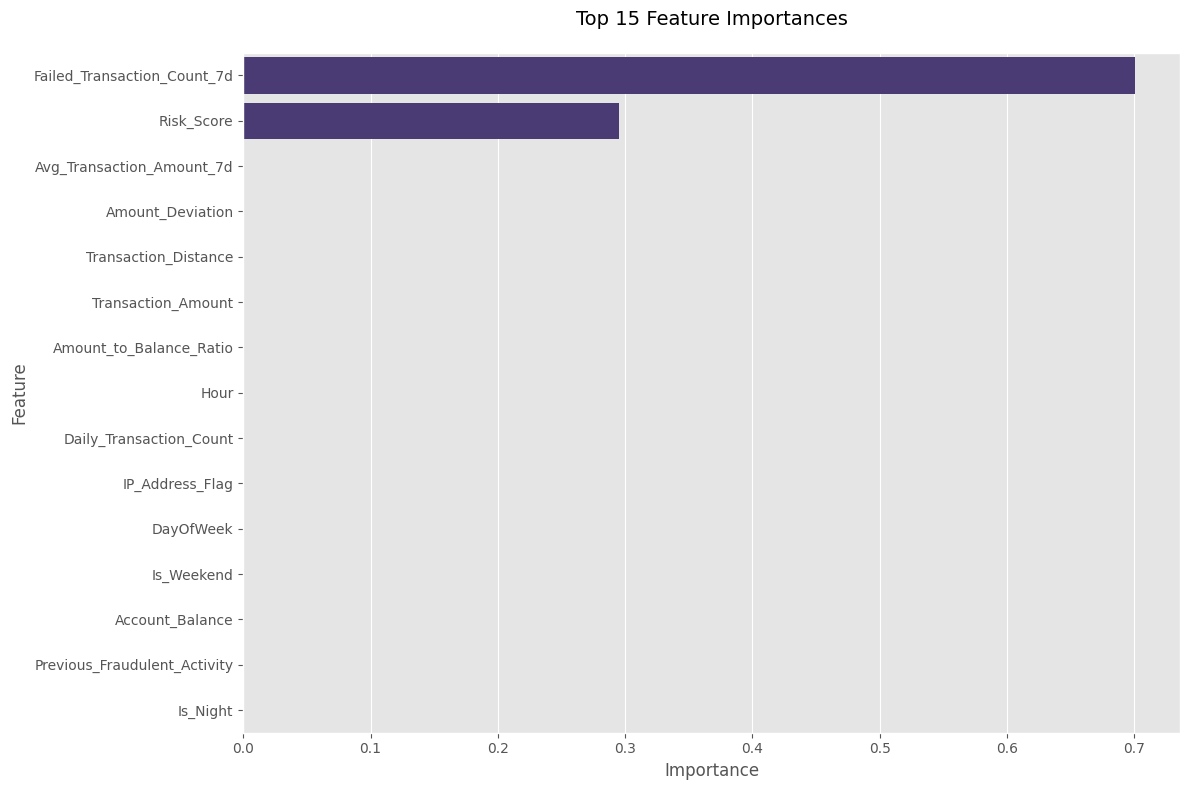


Generating SHAP explanations...


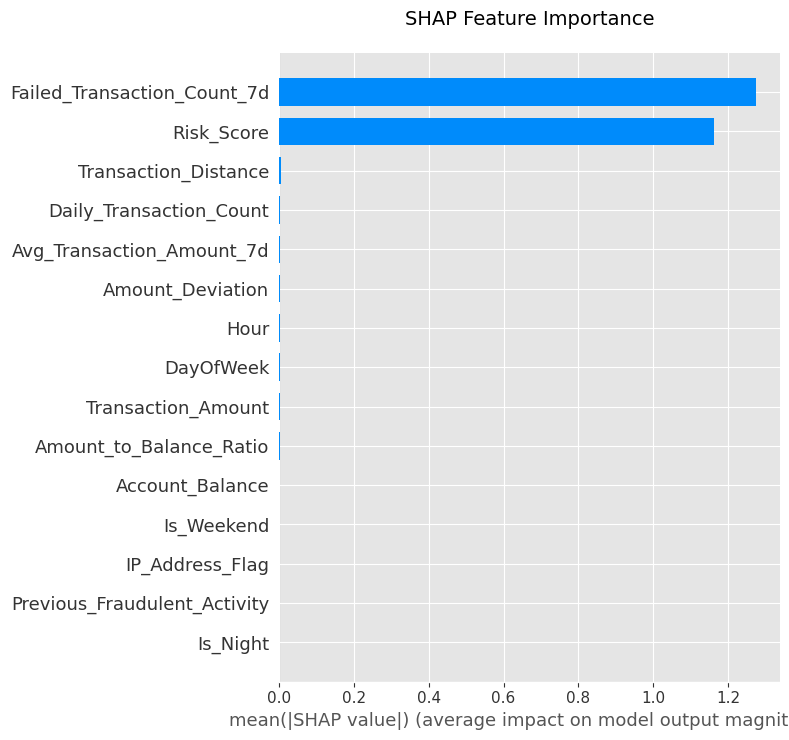


Generating SHAP force plot...


<Figure size 1200x400 with 0 Axes>

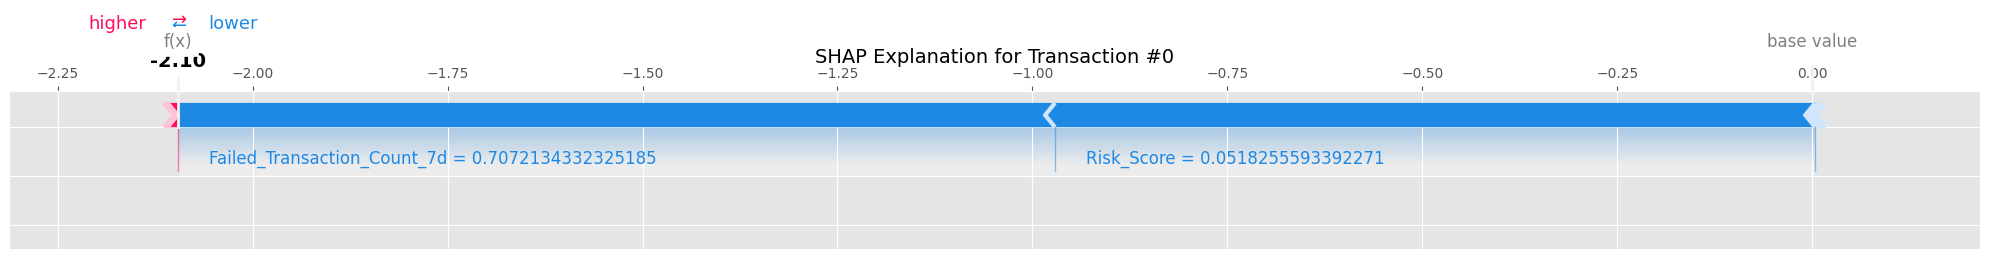


=== MODEL PERFORMANCE METRICS ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33933
           1       1.00      1.00      1.00     16067

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000


ROC-AUC Score: 1.0000
Average Precision Score: 1.0000


In [39]:
if __name__ == "__main__":
    main()